In [1]:
!pip install pandas
!pip install opencv-python

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Define paths of dataset
data_dir = r"C:\Users\Jia Yi Chan\Desktop\waste_classification_dataset2"

In [4]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# Image dimensions
img_height, img_width = 128, 128

# Define the batch size
batch_size = 32

Data Augmentation and Normalization

In [6]:
# Use ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training', # Automatically uses 80% of the data for training
    shuffle=True  
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', # Automatically uses 20% of the data for validation
    shuffle=False
)

Found 16719 images belonging to 12 classes.
Found 4175 images belonging to 12 classes.


Data Exploration

In [8]:
# Check the number of images in each class
class_counts = {class_name: sum(len(files) for _, _, files in os.walk(os.path.join(data_dir, class_name))) for class_name in os.listdir(data_dir)}
print("Number of images in each class:")
print(class_counts)

Number of images in each class:
{'battery': 945, 'cardboard': 1492, 'charger': 97, 'glass': 2259, 'laptop': 142, 'metal': 1366, 'mouse': 115, 'organic': 6732, 'paper': 2507, 'plastic': 1386, 'smartphone': 1642, 'trash': 2211}


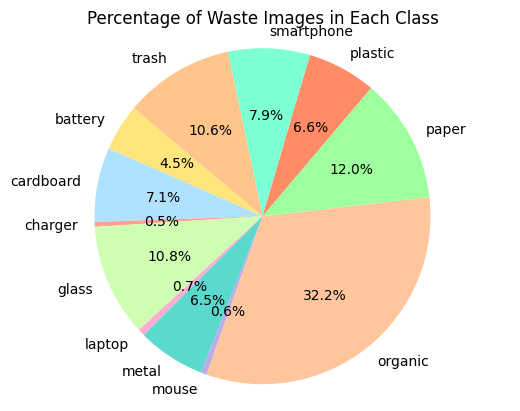

In [9]:
# Display the number of images in each class as a pie chart
labels = class_counts.keys()
sizes = class_counts.values()

colors = [
    '#FFE57C',  # Lighter Gold
    '#B0E2FF',  # Lighter SkyBlue
    '#FFA192',  # Lighter Tomato
    '#CFFFB2',  # Lighter PaleGreen
    '#FFAED2',  # Lighter HotPink
    '#5BD9CC',  # Lighter LightSeaGreen
    '#BDABE9',  # Lighter MediumPurple
    '#FFC69E',  # Lighter LightSalmon
    '#9EFF9E',  # Lighter LimeGreen
    '#FF8C66',  # Lighter OrangeRed
    '#7FFFD4',  # Lighter MediumSpringGreen
    '#FFC58B'   # Lighter DarkOrange
]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Waste Images in Each Class')
plt.show()

In [10]:
# Print the class indices
print("Class Indices:")
print(train_generator.class_indices)

Class Indices:
{'battery': 0, 'cardboard': 1, 'charger': 2, 'glass': 3, 'laptop': 4, 'metal': 5, 'mouse': 6, 'organic': 7, 'paper': 8, 'plastic': 9, 'smartphone': 10, 'trash': 11}


In [11]:
# Encode labels
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Number of classes: 12


Build Convolutional Neutral Network using Pre-Trained Model (ResNet)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

from tensorflow.keras.applications import VGG16  # Import VGG16 model

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the weights of the pre-trained layers
base_model.trainable = False

# Create a new model by adding layers on top of the VGG16 base
model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),  # You can adjust the number of units as needed
    Dropout(0.5),  # Add a dropout layer to reduce overfitting
    Dense(num_classes, activation='softmax')
])

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 16815180 (64.14 MB)
Trainable params: 2100492 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
# Define the batch size
batch_size = 32

# Continue training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10


522/522 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.6277

C:\Users\Jia Yi Chan\anaconda3\envs\wasteProj_env\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


522/522 [==============================] - 1775s 3s/step - loss: 1.1550 - accuracy: 0.6277 - val_loss: 0.8782 - val_accuracy: 0.7084
Epoch 2/10
522/522 [==============================] - 1762s 3s/step - loss: 0.8951 - accuracy: 0.7088 - val_loss: 0.8112 - val_accuracy: 0.7368
Epoch 3/10
522/522 [==============================] - 1646s 3s/step - loss: 0.8029 - accuracy: 0.7310 - val_loss: 0.8637 - val_accuracy: 0.7281
Epoch 4/10
522/522 [==============================] - 1616s 3s/step - loss: 0.7436 - accuracy: 0.7509 - val_loss: 0.8326 - val_accuracy: 0.7240
Epoch 5/10
522/522 [==============================] - 1620s 3s/step - loss: 0.6957 - accuracy: 0.7723 - val_loss: 0.8328 - val_accuracy: 0.7322
Epoch 6/10
522/522 [==============================] - 1541s 3s/step - loss: 0.6606 - accuracy: 0.7826 - val_loss: 0.7848 - val_accuracy: 0.7558
Epoch 7/10
522/522 [==============================] - 1609s 3s/step - loss: 0.6351 - accuracy: 0.7864 - val_loss: 0.8101 - val_accuracy: 0.7538
Epo

In [16]:
# Print the keys available in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


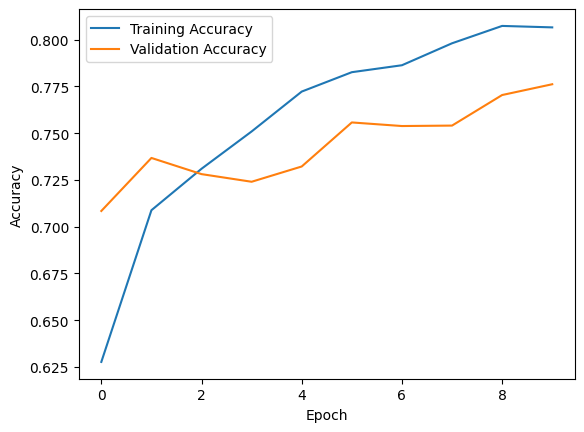

In [17]:
# Display the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Print both training and validation accuracies
print(f"Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")

Training Accuracy: 80.66%
Validation Accuracy: 77.62%


In [21]:
# Display the classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predictions for the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
val_labels = []
val_predictions = []

for i in range(val_steps):
    x_val, y_val = validation_generator.next()
    val_labels.extend(np.argmax(y_val, axis=1))
    val_predictions.extend(np.argmax(model.predict(x_val), axis=1))

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, val_predictions, zero_division=1))

1/1 [==============================] - 2s 2s/step


C:\Users\Jia Yi Chan\anaconda3\envs\wasteProj_env\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       189
           1       0.74      0.88      0.80       298
           2       1.00      0.00      0.00        19
           3       0.75      0.75      0.75       451
           4       0.79      0.39      0.52        28
           5       0.73      0.63      0.68       273
           6       0.75      0.13      0.22        23
           7       0.87      0.93      0.90      1346
           8       0.86      0.67      0.75       501
           9       0.56      0.46      0.50       277
          10       0.77      0.90      0.83       328
          11       0.54      0.56      0.55       410

    accuracy                           0.77      4143
   macro avg       0.76      0.59      0.61      4143
weighted avg       0.77      0.77      0.76      4143



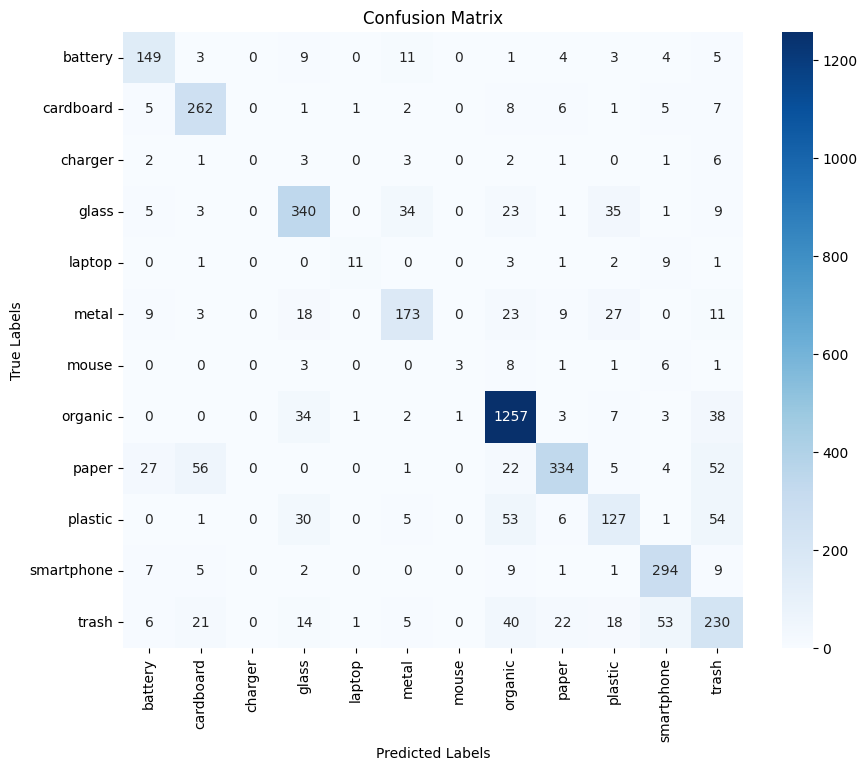

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

class_names = ['battery' , 'cardboard', 'charger', 'glass', 'laptop', 'metal', 'mouse', 'organic', 'paper', 'plastic', 'smartphone', 'trash']

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Save the entire model to a native Keras format
model.save("waste_classification_model_version15.keras")

# Print a message to indicate that the model has been saved
print("Model saved successfully.")

Model saved successfully.
